# 1. Import and Install Dependencies


In [ ]:
# %pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib


In [1]:
import cv2
import os
import time

import mediapipe as mp
import numpy as np

from matplotlib import pyplot as plt


In [2]:
print(f'Numpy Version: {np.__version__}')

Numpy Version: 1.19.5


# 2. Keypoints using MP Holistic


In [2]:
mp_holistic = mp.solutions.holistic  # model
mp_drawing = mp.solutions.drawing_utils  # utilities


In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False

    results = model.process(image)

    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    return image, results


In [5]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image,
                              results.face_landmarks,
                              mp_holistic.FACEMESH_CONTOURS)

    mp_drawing.draw_landmarks(image,
                              results.pose_landmarks,
                              mp_holistic.POSE_CONNECTIONS)

    mp_drawing.draw_landmarks(image,
                              results.left_hand_landmarks,
                              mp_holistic.HAND_CONNECTIONS)

    mp_drawing.draw_landmarks(image,
                              results.right_hand_landmarks,
                              mp_holistic.HAND_CONNECTIONS)


In [6]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(80, 110, 10),
                                                     thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80, 256, 121),
                                                     thickness=1, circle_radius=1))

    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80, 22, 10),
                                                     thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80, 44, 121),
                                                     thickness=2, circle_radius=2))

    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121, 22, 76),
                                                     thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121, 44, 250),
                                                     thickness=2, circle_radius=2))

    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245, 117, 66),
                                                     thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245, 66, 230),
                                                     thickness=2, circle_radius=2))


In [ ]:
mp_holistic.POSE_CONNECTIONS


In [ ]:
mp_drawing.draw_landmarks??


In [7]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)

        # draw_landmarks(image, results)
        draw_styled_landmarks(image, results)
        cv2.imshow('Opencv Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [8]:
len(results.face_landmarks.landmark)


468

In [9]:
results


mediapipe.python.solution_base.SolutionOutputs

In [10]:
draw_landmarks(frame, results)


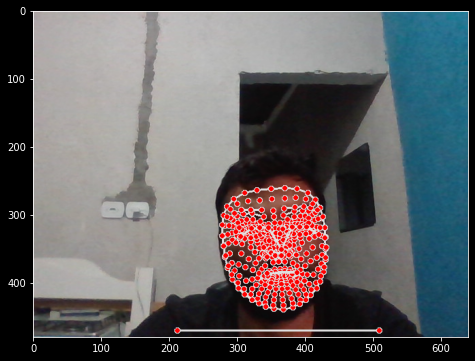

In [11]:
plt.figure(figsize=(24, 6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


# 3. Extract Keypoint Values


In [12]:
len(results.pose_landmarks.landmark)


33

In [13]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility]
                     for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z]
                     for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z]
                  for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z]
                  for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

    return np.concatenate([pose, face, lh, rh])


In [14]:
extract_keypoints(results).shape


(1662,)

In [15]:
results_test = extract_keypoints(results)


In [17]:
np.save('0', results_test)


In [18]:
np.load('0.npy')

array([ 0.54879308,  0.67750031, -1.39135253, ...,  0.        ,
        0.        ,  0.        ])

# 4. Setup Folders for Collection


In [18]:
DATA_PATH = os.path.join('MP_Data')
actions = np.array(['hello', 'thanks', 'iloveyou'])
no_sequences = 30
sequence_length = 30


In [20]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass


# 5. Collect Keypoint Values for Training and Testing


In [21]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # New Loop
    # loop through actions
    for action in actions:
        # loop through sequence aka video
        for sequence in range(no_sequences):
            # loop through video length aka sequence length
            for frame_num in range(sequence_length):
                # Read Feed
                ret, frame = cap.read()

                # Make Detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw Landmarks
                draw_styled_landmarks(image, results)

                # New Apply Collection Login
                if frame_num == 0:
                    cv2.putText(image, 'STARING COLLECTION', (120, 200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

                # New export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH,
                                        action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Show to screen
                cv2.imshow('Opencv Feed', image)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()


# 6. Preprocess Data and Create Labels and Features


In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [19]:
label_map = {label: num for num, label in enumerate(actions)}

In [20]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [21]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action,
                          str(sequence), '{}.npy'.format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])


In [22]:
np.array(sequences).shape

(90, 30, 1662)

In [23]:
np.array(labels).shape

(90,)

In [24]:
X = np.array(sequences)
X.shape

(90, 30, 1662)

In [25]:
y = to_categorical(labels).astype(int)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# 7. Build and Train LSTM Neural Network


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [28]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [29]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [31]:
res = [.7, 0.2, 0.1]

In [32]:
actions[np.argmax(res)]

'hello'

In [33]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


In [34]:
model.fit(x_train, y_train, epochs=200, callbacks=[tb_callback])

Epoch 1/200
3/3 [==============================] - 0s 151ms/step - loss: 6.4073 - categorical_accuracy: 0.3529
Epoch 2/200
3/3 [==============================] - 0s 89ms/step - loss: 18.9320 - categorical_accuracy: 0.3176
Epoch 3/200
3/3 [==============================] - 0s 103ms/step - loss: 9.9300 - categorical_accuracy: 0.2353
Epoch 4/200
3/3 [==============================] - 0s 118ms/step - loss: 9.1405 - categorical_accuracy: 0.3647
Epoch 5/200
3/3 [==============================] - 0s 140ms/step - loss: 14.9020 - categorical_accuracy: 0.3647
Epoch 6/200
3/3 [==============================] - 0s 99ms/step - loss: 16.1886 - categorical_accuracy: 0.2471
Epoch 7/200
3/3 [==============================] - 0s 117ms/step - loss: 21.9096 - categorical_accuracy: 0.2941
Epoch 8/200
3/3 [==============================] - 0s 122ms/step - loss: 14.6930 - categorical_accuracy: 0.3059
Epoch 9/200
3/3 [==============================] - 0s 100ms/step - loss: 7.2917 - categorical_accuracy: 0.341

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            442112    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
__________________________________________________

# 8. Make Predictions

In [36]:
res = model.predict(x_test)

In [37]:
actions[np.argmax(res[0])]

'iloveyou'

In [38]:
actions[np.argmax(y_test[0])]

'iloveyou'

# 9. Save Weights


In [47]:
model.save('action.h5')

In [48]:
del model

In [83]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy


In [39]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [40]:
yhat = model.predict(x_train)

In [42]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [43]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[52,  4],
        [ 3, 26]],

       [[55,  1],
        [ 1, 28]],

       [[54,  4],
        [ 5, 22]]], dtype=int64)

In [ ]:
multilabel_confusion_matrix??

In [44]:
accuracy_score(ytrue, yhat)

0.8941176470588236

# 11. Test in Real Time

In [45]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]


def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*40),
                      (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame


In [56]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set Mediapipe Model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read Feed
        ret, frame = cap.read()

        # Make Detection
        image, results = mediapipe_detection(frame, holistic)

        # Draw Landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction Logic
        keypoints = extract_keypoints(results)
        # sequence.insert(0, keypoints)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))

        # 3. Viz Logic
        if np.unique(predictions[-10:])[0] == np.argmax(res):
            if res[np.argmax(res)] > threshold:
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

        if len(sentence) > 5:
            sentence = sentence[-5:]

        # Viz probabilities
        image = prob_viz(res, actions, image, colors)

        # Show to Screen
        cv2.imshow('Opencv Feed', image)

        # Break Gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


IndexError: index 0 is out of bounds for axis 0 with size 0

In [57]:
cap.release()
cv2.destroyAllWindows()